## Setup

In [1]:
from typing import List
from abc import ABC, abstractmethod
import boto3
import json
import os
from dataclasses import dataclass
import tiktoken
from tonic_validate import ValidateScorer, Benchmark, LLMResponse, BenchmarkItem, Run
from tonic_validate.metrics import AnswerSimilarityMetric 
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
profile_name = os.environ["AWS_PROFILE_NAME"]
boto3.setup_default_session(profile_name=profile_name)

In [3]:
@dataclass
class RagAnswer():
    answer: str
    context_list: List[str]

class RagAgent(ABC):
    def __init__(
        self,
        knowledge_base_id: str,
        top_k: int,
        temperature: float,
        max_token_count: int
    ):
        self.knowledge_base_id = knowledge_base_id
        self.top_k = top_k
        self.temperature = temperature
        self.max_token_count = max_token_count

        self.bedrock_agent_runtime = boto3.client(
            service_name="bedrock-agent-runtime"
        )
        self.bedrock_runtime = boto3.client(
            service_name="bedrock-runtime"
        )
        
    def retrieve_context(self, query: str) -> List[str]:
        retrieval_results = self.bedrock_agent_runtime.retrieve(
            retrievalQuery={"text": query},
            knowledgeBaseId=self.knowledge_base_id,
            retrievalConfiguration={
                "vectorSearchConfiguration": {"numberOfResults": self.top_k}
            }
        )["retrievalResults"]

        return [x["content"]["text"] for x in retrieval_results]

    def augment_query(self, query: str, context_list: List[str]) -> str:
        prompt = "You are a helpful assistant that answers user's queries.\n"
        prompt += f"User Query: {query}\n"
        prompt += f"Query Context:\n\n"
        for context in context_list:
            prompt += f"{context}\n\n"
        prompt += "Answer the user query using the query context."

        return prompt

    @abstractmethod
    def get_response_from_model(self, model_prompt: str) -> str:
        pass
        
    def answer_question(self, question: str) -> RagAnswer:
        context_list = self.retrieve_context(question)
        model_prompt = self.augment_query(question, context_list)
        model_response = self.get_response_from_model(model_prompt)
        return RagAnswer(model_response, context_list)

class TitanRagAgent(RagAgent):
    def __init__(
        self,
        knowledge_base_id: str,
        top_k: int = 5,
        temperature: float = 0.2,
        max_token_count: int = 4000
    ):
        super().__init__(knowledge_base_id, top_k, temperature, max_token_count)
        self.model_id = "amazon.titan-text-express-v1"

    def get_response_from_model(self, model_prompt: str) -> str:
        
        body = {
            "inputText": model_prompt,
            "textGenerationConfig":
            {
                "temperature": self.temperature,
                "maxTokenCount": self.max_token_count,
            }
        }

        response = self.bedrock_runtime.invoke_model(
            modelId=self.model_id, body=json.dumps(body)
        )

        response_body = json.loads(response["body"].read())

        return response_body["results"][0]["outputText"]


class CohereRagAgent(RagAgent):
    def __init__(
        self,
        knowledge_base_id: str,
        top_k: int = 5,
        temperature: float = 0.2,
        max_token_count: int = 4000
    ):
        super().__init__(knowledge_base_id, top_k, temperature, max_token_count)
        self.model_id = "cohere.command-text-v14"

    def get_response_from_model(self, model_prompt: str) -> str:
        
        body = {
            "prompt": model_prompt,
            "temperature": self.temperature,
            "max_tokens": self.max_token_count,
        }

        response = self.bedrock_runtime.invoke_model(
            modelId=self.model_id, body=json.dumps(body)
        )

        response_body = json.loads(response["body"].read())

        return response_body["generations"][0]["text"]

def run_to_dataframe(run: Run) -> pd.DataFrame:
    return pd.DataFrame(
        {
            "reference_question": [x.reference_question for x in run.run_data],
            "reference_answer": [x.reference_answer for x in run.run_data],
            "llm_answer": [x.llm_answer for x in run.run_data],
            "llm_context": [json.dumps(x.llm_context) for x in run.run_data],
            "answer_similarity": [x.scores["answer_similarity"] for x in run.run_data]
        }
    )

In [4]:
with open("qa_pairs.json", "r") as f:
    qa_pairs = json.load(f)

# for testing
qa_pairs = qa_pairs

benchmark = Benchmark(
    questions=[x["question"] for x in qa_pairs],
    answers=[x["answer"] for x in qa_pairs]
)

# Titan

In [5]:
titan_knowledge_base_id = os.environ["TITAN_KNOWLEDGE_BASE_ID"]
titan_rag = TitanRagAgent(titan_knowledge_base_id)

In [6]:
def get_titan_response(benchmark_item: BenchmarkItem) -> str:
    query = benchmark_item.question
    return titan_rag.answer_question(query)

#### Test an example

In [7]:
benchmark_item = BenchmarkItem(
    question="What was Airbnb's monthly financial goal to achieve ramen profitability during their time at Y Combinator?",
    answer="Airbnb's monthly financial goal to achieve ramen profitability during their time at Y Combinator was $4000 a month."
)

print(get_titan_response(benchmark_item).answer)


$4000


#### Run through all the questions

In [8]:
with ThreadPoolExecutor(max_workers=10) as executor:
    raw_titan_responses = list(tqdm(executor.map(get_titan_response, benchmark.items), total=len(benchmark.items)))


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:33<00:00,  1.65it/s]


In [9]:
titan_responses = [
    LLMResponse(
        llm_answer=r.answer, llm_context_list=r.context_list, benchmark_item=bi
    ) for r, bi in zip(raw_titan_responses, benchmark.items)
]

In [10]:
scorer = ValidateScorer([AnswerSimilarityMetric()])
titan_run = scorer.score_run(titan_responses)

In [11]:
titan_run_df = run_to_dataframe(titan_run)
titan_run_df.to_csv("titan_run.csv", index=False)

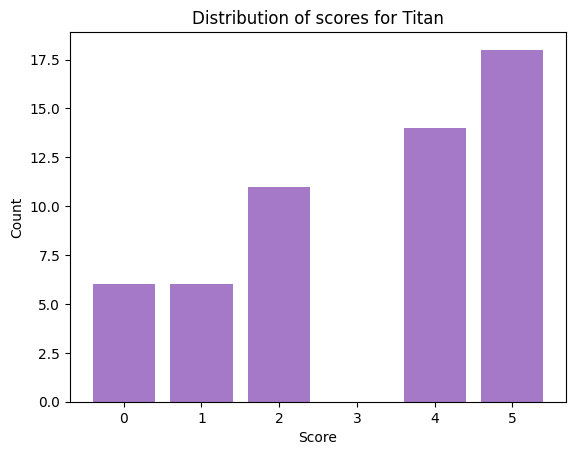

In [12]:
titan_answer_similarity_scores = pd.Series([x.scores["answer_similarity"] for x in titan_run.run_data])
category_counts = titan_answer_similarity_scores.value_counts()
plt.bar(category_counts.index, category_counts.values)

plt.title('Distribution of scores for Titan')
plt.xlabel('Score')
plt.ylabel('Count')

plt.bar(category_counts.index, category_counts.values, color='#A679C8')

# Remove all scores except whole numbers
plt.xticks(range(0, 6, 1))

plt.show()

# Cohere

In [13]:
cohere_knowledge_base_id = os.environ["COHERE_KNOWLEDGE_BASE_ID"]
cohere_rag = CohereRagAgent(cohere_knowledge_base_id)

In [14]:
def get_cohere_response(benchmark_item: BenchmarkItem) -> str:
    query = benchmark_item.question
    return cohere_rag.answer_question(query)

In [15]:
benchmark_item = BenchmarkItem(
    question="What was Airbnb's monthly financial goal to achieve ramen profitability during their time at Y Combinator?",
    answer="Airbnb's monthly financial goal to achieve ramen profitability during their time at Y Combinator was $4000 a month."
)

print(get_cohere_response(benchmark_item).answer)

 Airbnb's monthly financial goal to achieve ramen profitability during their time at Y Combinator was $3500 for rent, and $500 for food, totaling $4,000 per month. 

This goal was set as the company aimed to make just enough money to pay the founders' living expenses. This threshold, as Paul Graham notes, is important for startups because it is the point at which a company can operate independently of investors. 


In [16]:
with ThreadPoolExecutor(max_workers=10) as executor:
    raw_cohere_responses = list(tqdm(executor.map(get_cohere_response, benchmark.items), total=len(benchmark.items)))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [01:23<00:00,  1.52s/it]


In [17]:
cohere_responses = [
    LLMResponse(
        llm_answer=r.answer, llm_context_list=r.context_list, benchmark_item=bi
    ) for r, bi in zip(raw_cohere_responses, benchmark.items)
]

In [18]:
scorer = ValidateScorer([AnswerSimilarityMetric()])
cohere_run = scorer.score_run(cohere_responses)

In [19]:
cohere_run_df = run_to_dataframe(cohere_run)
cohere_run_df.to_csv("cohere_run.csv", index=False)

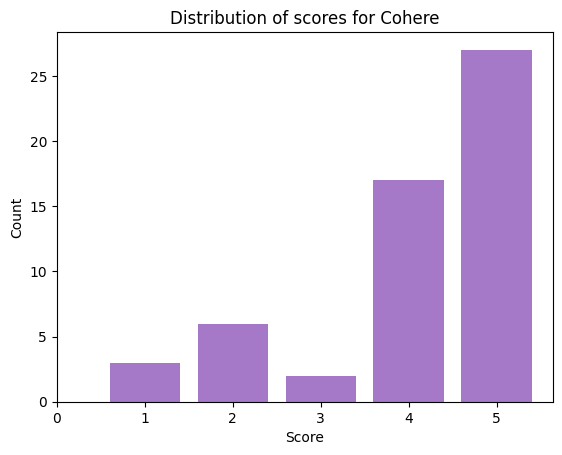

In [20]:
cohere_answer_similarity_scores = pd.Series([x.scores["answer_similarity"] for x in cohere_run.run_data])
category_counts = cohere_answer_similarity_scores.value_counts()
plt.bar(category_counts.index, category_counts.values)

plt.title('Distribution of scores for Cohere')
plt.xlabel('Score')
plt.ylabel('Count')

plt.bar(category_counts.index, category_counts.values, color='#A679C8')

# Remove all scores except whole numbers
plt.xticks(range(0, 6, 1))

plt.show()

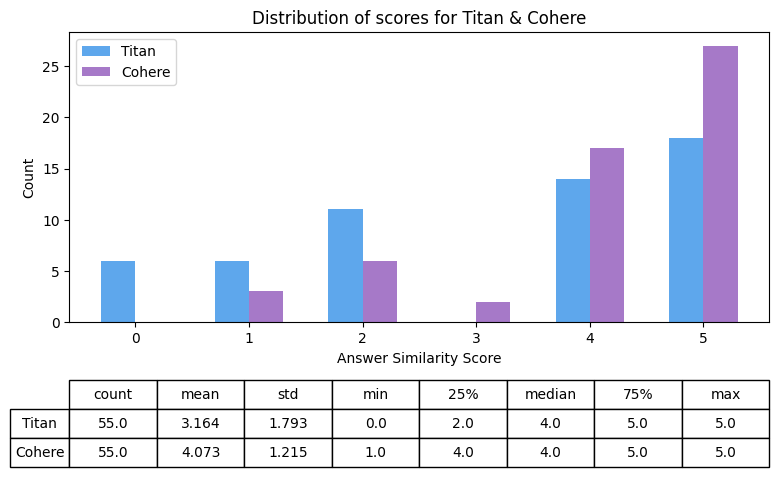

In [21]:
import matplotlib.pyplot as plt
import numpy as np

combined_scores = pd.DataFrame({
    "Titan": list(titan_run_df["answer_similarity"]),
    "Cohere": list(cohere_run_df["answer_similarity"])
})

# Position of bars on x-axis
ind = np.arange(6)

# Figure size
plt.figure(figsize=(10,5))

# Width of a bar 
width = 0.3

haystack_counts = combined_scores["Titan"].value_counts().reindex([0,1,2,3,4,5], fill_value=0)
plt.bar(haystack_counts.index, haystack_counts.values, width, label="Titan", color="#5EA7EC")

langchain_counts = combined_scores["Cohere"].value_counts().reindex([0,1,2,3,4,5], fill_value=0)
plt.bar(langchain_counts.index + width, langchain_counts.values, width, label="Cohere", color="#A679C8")

plt.title('Distribution of scores for Titan & Cohere')
plt.xlabel('Answer Similarity Score')
plt.ylabel('Count')

# Remove all scores except whole numbers
plt.xticks(ind + width / 2, range(0, 6, 1))

plt.legend(loc='best')

# Rounding the descriptive statistics to 3 significant figures
statistics_df = combined_scores.describe()
# Change 50% to 50% (median)
statistics_df = statistics_df.rename(index={'50%': 'median'})
rounded_statistics_df = statistics_df.round(3)

# Transposing the descriptive statistics table for horizontal display
rounded_statistics_df = rounded_statistics_df.T

# Adding the table below the histogram
table = plt.table(cellText=rounded_statistics_df.values,
                  colWidths=[0.1] * len(rounded_statistics_df.columns),
                  rowLabels=rounded_statistics_df.index,
                  colLabels=rounded_statistics_df.columns,
                  cellLoc = 'center', rowLoc = 'center',
                  loc='bottom', bbox=[0.0, -0.5, 1.0, 0.3])

plt.subplots_adjust(left=0.2, bottom=0.3)
plt.savefig("titan_v_cohere.png", facecolor='white', bbox_inches='tight')

plt.show()